In [6]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools import tool

import os
import re
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain.schema import Document

from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser
import json

from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser

from typing_extensions import TypedDict, List, Dict
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph

from langchain_ollama import ChatOllama
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

import uuid 
import pandas as pd

In [7]:
# Define the path for the persistent ChromaDB
# CHROMA_PERSIST_DIRECTORY = "/home/manohar/researchProject/chroma_db"
PDF_DIRECTORY = "./pdfs"

# Define paths for the persistent ChromaDB instances
CHROMA_DOCUMENTS_DIRECTORY = "./documents_db"
GENERATED_QUESTIONS_DIRECTORY = "./questions_df"

# Define unique collection names
DOCUMENTS_COLLECTION_NAME = "pdf_documents"

# Initialize embeddings
embeddings = NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local")


In [8]:
# Code block to process PDFs and create a persistant vector store
def load_and_process_documents(directory: str):
    document_loader = PyPDFDirectoryLoader(directory)
    documents = document_loader.load()
    
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=0
    )
    
    return text_splitter.split_documents(documents)
print("Processing all PDF's")
all_docs = load_and_process_documents(PDF_DIRECTORY)
print("Processing Complete")
all_pdf_names_in_folder = set([doc.metadata["source"] for doc in all_docs])

def get_or_create_vectorstore():
    # Check if the Chroma database already exists
    if os.path.exists(CHROMA_DOCUMENTS_DIRECTORY):
        print("Loading existing Chroma database...")
        vectorstore = Chroma(persist_directory=CHROMA_DOCUMENTS_DIRECTORY, embedding_function=embeddings, collection_name=DOCUMENTS_COLLECTION_NAME)
        existing_pdf_in_db = set([i["source"] for i in vectorstore.get()["metadatas"]])
        if len(list(set(existing_pdf_in_db).difference(all_pdf_names_in_folder))) != 0:
            print("Adding New PDF's to the DB")
            # new_docs = list(set(existing_pdf_in_db).difference(all_pdf_names_in_folder))
            new_docs = [doc for doc in all_docs if doc.metadata.get("source") not in existing_pdf_in_db]
            vectorstore.add_documents(new_docs)
            vectorstore.persist()

        return vectorstore
    
    print("Creating new Chroma database...")
    # doc_splits = load_and_process_documents(PDF_DIRECTORY)
    
    # Create and persist the Chroma database
    vectorstore = Chroma.from_documents(
        documents=all_docs,
        embedding=embeddings,
        persist_directory=CHROMA_DOCUMENTS_DIRECTORY,
        collection_name=DOCUMENTS_COLLECTION_NAME
    )
    vectorstore.persist()
    return vectorstore

vectorstore = get_or_create_vectorstore()
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})


Processing all PDF's
Processing Complete
Loading existing Chroma database...


In [9]:
## Ganerating Questions and saving in a Pandas DF for further use.
def extract_questions_fallback(text: str) -> List[Dict]:
    """
    Fallback method to extract questions when JSON parsing fails.
    """
    questions = []
    pattern = r'Question (\d+): (.+?)\s*Difficulty:\s*(\w+)'
    matches = re.findall(pattern, text, re.MULTILINE | re.DOTALL)
    
    for number, question, difficulty in matches:
        questions.append({
            "question": question.strip(),
            "difficulty": difficulty.strip().lower(),
        })
    
    return questions

llm = ChatOllama(
        model="llama3.1",
        temperature=0.2,
    )

def generate_questions(doc): 
    
    question_prompt = PromptTemplate(
        template="""You are an expert in generating insightful and contextually relevant questions from academic or research-based text. Your goal is to analyze the provided content and create **three diverse, meaningful, and answerable questions** that reflect the key ideas, findings, or insights from the text.

        However, **do not generate questions** if the text primarily consists of irrelevant or low-value content such as:
        - Author names, affiliations, emails
        - Section titles, paper titles, or chapter headings
        - Hyperlinks, URLs, or references
        - Acknowledgments, funding information, or similar administrative content
        - Purely metadata like figure captions, data tables, or bibliography

        ### Guidelines:
        1. **Assess the quality** of the provided text before generating questions.
        2. Only generate questions if the text contains **substantial academic content** (e.g., theories, research methods, findings, arguments, or significant discussions).
        3. Ensure the questions reflect **different aspects** of the text (e.g., conceptual understanding, methodology, implications, analysis) and are not repetitive.
        4. Avoid any references to the authors, article, study, or document itself. The questions should not contain phrases like:

            - "As discussed in this article"
            - "How do the authors propose"
            - "According to this study"
            - "From this text"
            - "as per the text"
        4. If the text does not meet these quality criteria, respond with: "**The provided text does not contain sufficient content for generating meaningful questions.**"

        ### Format:
        - For relevant text, output the questions as follows:
        ```
        Question 1: [Insightful, specific question]
        Difficulty: [easy/medium/hard]
        Question 2: [Insightful, specific question]
        Difficulty: [easy/medium/hard]
        Question 3: [Insightful, specific question]
        Difficulty: [easy/medium/hard]
        ```

        - If no questions can be generated, output:
        ```
        The provided text does not contain sufficient content for generating meaningful questions.
        ```

        **Generated Questions:** 

        Text: {text}
        """,
        input_variables=["text"],
    )
    question_chain = LLMChain(llm=llm, prompt=question_prompt, output_key="questions")
    
    result = question_chain.invoke({"text": doc.page_content})
    questions_text = result["questions"]
    # print(f"After Generation: {questions_text}")
    
    try:
        # print("In Try block")
        questions = json.loads(questions_text)
        if isinstance(questions, dict) and "questions" in questions:
            questions = questions["questions"]
            # print("inside if in try block")
            # print(questions)
    except json.JSONDecodeError:
        # print("inside except block")
        questions = extract_questions_fallback(questions_text)
        # print(questions)
    
    for idx, q in enumerate(questions):
        q["question_index"] = idx 
        q["source"] = doc.metadata.get("source")
        q["page"] = doc.metadata.get("page")
        q["page_content"] = doc.page_content 
    
    return questions

allquest = []

if os.path.isfile(GENERATED_QUESTIONS_DIRECTORY + "/GeneratedQuestions.csv"):
    print("Loading Previously Generated Questions DB...")
    QuestionsDf = pd.read_csv(GENERATED_QUESTIONS_DIRECTORY + "/GeneratedQuestions.csv")
else:
    os.makedirs(GENERATED_QUESTIONS_DIRECTORY)
    QuestionsDf = pd.DataFrame(columns=["question", "difficulty", "source", "page", "page_content"])

QuestionsDf["SourcePage"] = QuestionsDf["source"] + "" + QuestionsDf["page"].astype(str)

for doc in all_docs:
    if "".join(map(str, doc.metadata.values())) not in QuestionsDf.SourcePage.unique():
        questions = generate_questions(doc)
        allquest.extend(questions)
allquest_df = pd.DataFrame(allquest)
QuestionsDf = pd.concat([QuestionsDf, allquest_df], ignore_index=True)


QuestionsDf.to_csv(GENERATED_QUESTIONS_DIRECTORY + "/GeneratedQuestions.csv")


In [20]:
len(all_docs)

1691

In [21]:
## Creatring all the tools and Nodes required for APP

# Creatiug a WebSearch tool for the APP workflow
web_search_tool = TavilySearchResults()

# Creating Nodes for Graphs
rag_chain_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

rag_chain = rag_chain_prompt | llm | StrOutputParser()

retrieval_grader_prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = retrieval_grader_prompt | llm | JsonOutputParser()

############## Defining GraphState Lang Graph
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]
    source: str


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]

    # Determine the source based on the last step
    source = "WebSearch" if "web_search" in steps else "RAG"
    
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
        "source": source,
    }

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"


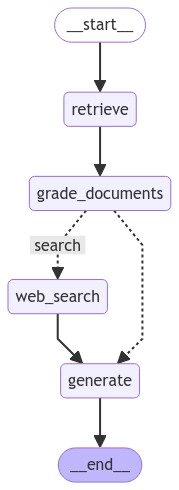

In [22]:
# LangGraph Creating Graph Workflow
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [23]:
###############
def predict_custom_agent_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    
    state_dict = custom_graph.invoke(
        {"question": example["input"], "steps": []}, config
    )
    
    output = {
        "response": state_dict["generation"],
        "steps": state_dict["steps"],
        "source": state_dict["source"]
    }
    
    if state_dict["source"] == "RAG":
        # Include the relevant documents for RAG-based outputs with file name and page number
        relevant_docs = []
        for doc in state_dict["documents"]:
            doc_info = {
                "content": doc.page_content,
                "file_name": doc.metadata.get("source", "Unknown"),
                "page_number": doc.metadata.get("page", "Unknown")
            }
            relevant_docs.append(doc_info)
        output["relevant_documents"] = relevant_docs
    
    return output

In [25]:
QuestionsDf.head(2)
QuestionsDf.shape
# QuestionsDf.source.unique

(3871, 7)

In [26]:
QuestionsDf.drop_duplicates(["question"])

,question,difficulty,source,page,page_content,SourcePage,question_index
0,What are some key features of a fully function...,medium,/home/manohar/researchProject/pdfs/Metaverse b...,3,ARTICLE INFO \nKeywords: \nAvatars \nAugmente...,NaN,0.0
1,How might the metaverse impact business practi...,hard,/home/manohar/researchProject/pdfs/Metaverse b...,3,ARTICLE INFO \nKeywords: \nAvatars \nAugmente...,NaN,1.0
2,What are some potential socio-economic implica...,medium,/home/manohar/researchProject/pdfs/Metaverse b...,3,ARTICLE INFO \nKeywords: \nAvatars \nAugmente...,NaN,2.0
3,What are some potential societal effects that ...,medium,/home/manohar/researchProject/pdfs/Metaverse b...,3,formational as the distinct lines between phys...,NaN,0.0
4,How might the transformative impact of the met...,hard,/home/manohar/researchProject/pdfs/Metaverse b...,3,formational as the distinct lines between phys...,NaN,1.0
...,...,...,...,...,...,...,...
3866,How does Ning Zhang's role as an Associate Edi...,easy,/home/manohar/researchProject/pdfs/A_Survey_on...,33,"Ning Zhang (Senior Member, IEEE) received the\...",NaN,1.0
3867,What are some potential implications of Ning Z...,medium,/home/manohar/researchProject/pdfs/A_Survey_on...,33,"Ning Zhang (Senior Member, IEEE) received the\...",NaN,2.0
3868,What are the primary areas of research interes...,easy,/home/manohar/researchProject/pdfs/A_Survey_on...,33,Chair for several international conferences an...,NaN,0.0
3869,How does Dongxiao Liu's work on intelligent tr...,medium,/home/manohar/researchProject/pdfs/A_Survey_on...,33,Chair for several international conferences an...,NaN,1.0


In [28]:
import numpy as np
random_questions = np.random.randint(0,QuestionsDf.shape[0] , size=20)

In [29]:
for i in random_questions:
    print(f"Generating for question: {i}")
    print(f"Question: " + QuestionsDf["question"][i])
    example = {"input": QuestionsDf["question"][i]}
    response = predict_custom_agent_answer(example)
    print(f'Answer: {response["response"]} ')
    print(f'Source: {response["source"]} ')
    if response["source"] != "WebSearch":
        print(f'Relavent Documents: {response["relevant_documents"]}')
    print(f"--------------------------------------------------")

Generating for question: 304
Question: How do the underlying purposes of the metaverse, like board meetings, concerts, art exhibitions, or education, shape the design elements for user engagement in this virtual environment?
Answer: The underlying purposes of the metaverse, such as board meetings, concerts, art exhibitions, or education, shape the design elements for user engagement by influencing the technical features, social elements, and psychological states that drive user interaction. For example, in educational settings, the metaverse can extend learning opportunities and mirror real-world environments to enhance learner experiences. This, in turn, affects the design of avatars, virtual world landscapes, and other technical features that facilitate user engagement. 
Source: RAG 
Relavent Documents: [{'content': 'metaverse.  \nResearch Topic Possible Research Questions \nUser Engagement in the \nmetaverse What does user engagement in the metaverse constitute \n(e.g., focused atte

In [16]:
Q = 40
print(f"Question: " + QuestionsDf["question"][Q])
example = {"input": QuestionsDf["question"][Q]}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
if response["source"] != "WebSearch":
    print(f'Relavent Documents: {response["relevant_documents"]}')

Question: How does the concept of similarity to the real world serve as an example for distinguishing between different types of metaverses, particularly in terms of environment and interface?
Answer: The concept of similarity to the real world serves as an example for distinguishing between different types of metaverses by classifying environments into realistic, unrealistic, and fused categories. Realistic metaverses faithfully reflect geography and physical elements, while unrealistic ones offer more degrees of freedom without constraints. This classification also applies to interfaces, with 3D, immersive, and physical methods being used to categorize the metaverse. 
Source: RAG 
Relavent Documents: [{'content': 'improved. 4) Due to the limitations of offline social activity (e.g., \nCovid-19), interest in the virtual world has grown. \n2.1.1.1. Definition. We classify the definitions of the metaverse into \nfour types —environment, interface, interaction, and social value —by \nsum

In [17]:
Q = 1535
print(f"Question: " + QuestionsDf["question"][Q])
example = {"input": QuestionsDf["question"][Q]}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
if response["source"] != "WebSearch":
    print(f'Relavent Documents: {response["relevant_documents"]}')

Question: How can multidisciplinary perspectives help address emerging challenges and opportunities in the metaverse, and what implications does this have for research, practice, and policy?
Answer: Multidisciplinary perspectives can help address emerging challenges in the metaverse by considering various aspects such as sustainability, education, health, and social implications. This approach can lead to a better understanding of the potential benefits and drawbacks of the metaverse, including its impact on vulnerable members of society. Research agendas have been proposed to explore these topics further, highlighting the need for multidisciplinary research to mitigate negative impacts and maximize positive outcomes. 
Source: RAG 
Relavent Documents: [{'content': 'The potential for organisations to adapt their business models and \noperational capacity to function on the metaverse is significant, with \ntransformational impacts on marketing, tourism, leisure and hospitality \ncitizen-

In [18]:
Q = 705
print(f"Question: " + QuestionsDf["question"][Q])
example = {"input": QuestionsDf["question"][Q]}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
if response["source"] != "WebSearch":
    print(f'Relavent Documents: {response["relevant_documents"]}')

Question: What are the potential benefits of using NFTs as a marketing tool for hotels, and how can they enhance guest experiences?
Answer: The potential benefits of using NFTs as a marketing tool for hotels include boosting brand awareness by creating and trading NFTs related to hotel intellectual property, enhancing guest experiences through interactive digital art, and crowdfund development ventures. Hotels can also use NFTs to connect with their audience, deliver meanings and messages of experiences, and support brand-related causes. This can lead to increased engagement and loyalty among customers. 
Source: RAG 
Relavent Documents: [{'content': '6.to authenticate participation in an educational event, seminar, con-\nference and provide educational accreditation to attendees  \n7. boost brand awareness by creating and trading NFTs related to brand \nintellectual property (e.g., brand colours, hotel room designs, menu \ndesign, food recipes) \nInterest in collectibles and NFTs has i

In [19]:
Q = 4
print(f"Question: " + all_generated_questions[Q]["question"])
example = {"input": all_generated_questions[Q]["question"]}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
print(f'Relavent Documents: {response["relevant_documents"]} ')

NameError: name 'all_generated_questions' is not defined

In [ ]:
Q = 5
print(f"Question: " + all_generated_questions[Q]["question"])
example = {"input": all_generated_questions[Q]["question"]}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
print(f'Relavent Documents: {response["relevant_documents"]} ')

Question: Based on the information provided, what is the proposed outcome of this study, and who are its intended beneficiaries?
Answer: The proposed outcome of this study is a future research agenda that details potential avenues for further academic analysis of the metaverse's impact on society. The intended beneficiaries of this study are researchers, businesses, and vulnerable users who will benefit from a better understanding of the metaverse's benefits and challenges. This research aims to balance the positive aspects with the negative impacts on vulnerable users. 
Source: RAG 
Relavent Documents: [{'content': 'Hughes, Cheung, et al., (2022); Dwivedi, Hughes et al. (2021; 2020); \nDwivedi et al. (2015), to bring together the insights from an invited list \nof established researchers and gain a multi-perspective on the trans -\nformative potential and impact of the metaverse and subsequently, \npropose a future research agenda. \nThe remainder of this study is set out as follows: 

In [ ]:
Q = 6
print(f"Question: " + all_generated_questions[Q]["question"])
example = {"input": all_generated_questions[Q]["question"]}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
print(f'Relavent Documents: {response["relevant_documents"]} ')

Question: What sectors of society are expected to be impacted by the transformative impact of the metaverse, according to researchers?
Answer: According to researchers, sectors expected to be impacted by the transformative impact of the metaverse include marketing, education, healthcare, as well as societal effects relating to social interaction factors. Additionally, issues such as trust, privacy, bias, disinformation, and application of law are also expected to be affected. The metaverse is also likely to have a significant impact on vulnerable people. 
Source: RAG 
Relavent Documents: [{'content': 'formational as the distinct lines between physical and digital are likely to be somewhat blurred from current \nperceptions. However, although the technology and infrastructure does not yet exist to allow the development of \nnew immersive virtual worlds at scale - one that our avatars could transcend across platforms, researchers are \nincreasingly examining the transformative impact of 

In [ ]:
Q = 6
print(f"Question: " + all_generated_questions[Q]["question"])
query = all_generated_questions[Q]["question"]
example = {"input": query}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
print(f'Relavent Documents: {response["relevant_documents"]} ')

Question: **What is the primary purpose of the Semantic Engine in a healthcare service?**
Answer: The primary purpose of the Semantic Engine in a healthcare service is to enhance semantic interoperability across dispersed health information systems by feeding back JSON files to show semantic definitions in FHIR along with understandings by implementors. It also eliminates semantic ambiguity by providing corresponding examples in different local health information systems. This is achieved through an ostensive approach that supplements the current lexical approach in semantic exchange. 
Source: RAG 
Relavent Documents: [{'content': 'adopted in the healthcare domain (Dusetzina et\xa0al., 2014).\nThe key purpose of this design is to employ FHIR in \na computational method that leverages the advantages of \nthe knowledge graph to process semantics, and takes pri-\nvacy and security concerns into account. The separation of \nsemantic processing and data storage can reduce the problem \nof d

In [ ]:
# Q = 6
# print(f"Question: " + all_generated_questions[Q]["question"])
query = "What is llama?"
example = {"input": query}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
# print(f'Relavent Documents: {response["relevant_documents"]} ')

Question: **What is the primary purpose of the Semantic Engine in a healthcare service?**
Answer: A llama is a domesticated South American camelid, widely used as a pack animal by Andean cultures since the pre-Columbian era. They are social animals that live in herds and have soft wool with minimal lanolin content. Llamas can learn simple tasks after repetition and are known for their ability to carry packs over rough terrain. 
Source: WebSearch 


In [ ]:
Q = 7
print(f"Question: " + all_generated_questions[Q]["question"])
query = all_generated_questions[Q]["question"]
example = {"input": query}
response = predict_custom_agent_answer(example)
print(f'Answer: {response["response"]} ')
print(f'Source: {response["source"]} ')
print(f'Relavent Documents: {response["relevant_documents"]} ')

Question: **How does the Semantic Engine handle data from multiple local databases?**
Answer: The Semantic Engine handles data from multiple local databases by translating queries, obtaining data from local databases, and merging them to return responses to users. It uses the FHIR knowledge graph as a user interface and semantic interpreter to facilitate data exchange between dispersed information systems. The querying processor redirects user queries to different local databases and collects query results to assemble the data according to relationships between nodes. 
Source: RAG 
Relavent Documents: [{'content': '2015) for its development. In order to facilitate data \nexchange between dispersed information systems, the \nlocal data require connections to the Semantic Engine. \nThis research transforms the properties of local data into \nthese property nodes; values of local data are retrieved \nFig. 6  Semantic query processing flow', 'file_name': '/home/manohar/researchProject/pdfs